# Import libraries and dataset

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Input, Flatten
from keras.models import Model

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 5s 0us/step


# Data exploration and preprocessing

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2569 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 24
Number of test batches: 11


Il dataset contiene in totale 3670 immagini divise in 5 classi. Tale dataset è stato diviso in train, validation e test set.

Di seguito il plot di alcune immagini del train set e relativa label one hot encoded:

[1 0 0 0 0] = daisy

[0 1 0 0 0] = dandelion

[0 0 1 0 0] = roses

[0 0 0 1 0] = sunflowers

[0 0 0 0 1] = tulips

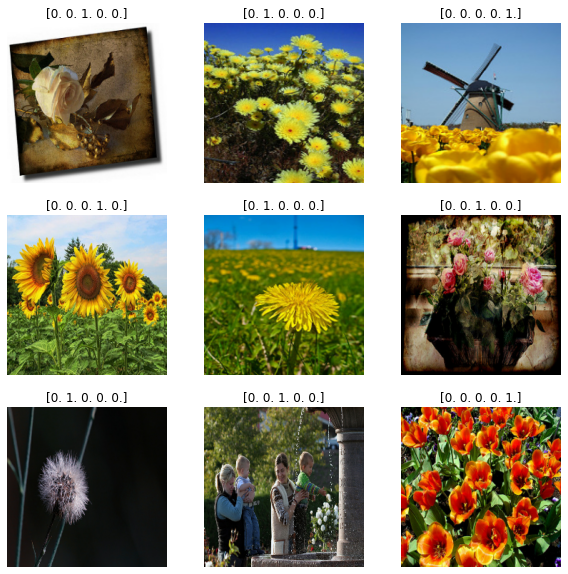

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(labels[i].numpy()))
    plt.axis("off")

Utilizzo del precaricamento con buffer per caricare le immagini dal disco senza che l'I/O diventi un blocco. (miglioramento performance)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Struttura della rete VGG16

In seguito la struttura completa della CNN VGG16.

In [ ]:
from tensorflow.keras.models import Model
base_model = VGG16(weights='imagenet')
base_model.summary()

553476096/553467096 [==============================] - 20s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

# Taglio 1

## Taglio al layer 'block4_pool'



In [ ]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)
model.summary()
model.trainable = False # la parte di modello importata è resa non trainabile

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Creazione modello da mettere in coda e del modello complessivo
Il modello scelto da mettere in coda è per tutti e tre i tagli il medesimo: una rete neurale fully connected. Nel primo layer, per renderlo compatibile con il livello precedente convoluzionale, è utilizzata la funzione "Flatten()", seguita da due livelli fully connected da 256 e 128 neuroni. Infine l'ultimo layer per la predizione contiene 5 neuroni, come il numero delle classi del dataset (e l'utilizzo della funzione di attivazione softmax). Inoltre l'input viene preprocessato oppurtunamente per la rete VGG16.

In [ ]:
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Activation

l1 = tf.keras.layers.Dense(256, activation='relu')
l2 = tf.keras.layers.Dense(128, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation="softmax") #5 classi

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = l1(x)
x = l2(x)
outputs = prediction_layer(x)
my_model = tf.keras.Model(inputs, outputs)

#Checking the final model summary
my_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 model (Functional)          (None, 14, 14, 512)       7635264   
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                           

## Training
Vengono utilizzate solo 3 epochs nel training perchè altrimenti i modelli tenderanno ad andare in overfitting.

In [ ]:
base_learning_rate = 0.001
my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
n_epochs = 3
history = my_model.fit(train_ds,
                    epochs=n_epochs,
                    validation_data=val_ds)

Epoch 1/3
81/81 [==============================] - 54s 396ms/step - loss: 726.3643 - accuracy: 0.6384 - val_loss: 111.1984 - val_accuracy: 0.7931
Epoch 2/3
81/81 [==============================] - 25s 308ms/step - loss: 74.2299 - accuracy: 0.8895 - val_loss: 73.7667 - val_accuracy: 0.8611
Epoch 3/3
81/81 [==============================] - 25s 301ms/step - loss: 20.5994 - accuracy: 0.9471 - val_loss: 94.6306 - val_accuracy: 0.8385


## Risultati

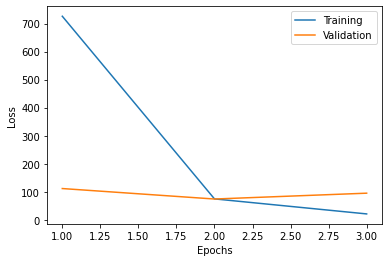

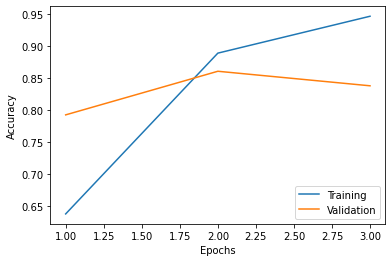

In [ ]:
#plot training history

from matplotlib import pyplot as plt
x_plot = list(range(1, n_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

In [ ]:
my_model.evaluate(test_ds.take(-1))

11/11 [==============================] - 3s 223ms/step - loss: 131.0116 - accuracy: 0.8040


[131.01162719726562, 0.8039772510528564]

Il modello risultante con 3 epochs stava iniziando ad andare in overfitting poichè la validation loss stava iniziando ad aumentare e la validation  accuracy iniziava a diminuire e divergere dalla training accuracy. Sul test set si ottengono risulati in linea con quelli del validation set all'ultima epoch (circa 80%).

# Taglio 2
Ripetiamo il procedimento cambiando il punto di "taglio" della VGG16.  In particolare prendiamo fino al layer 'block2_pool'.

In [ ]:
# base_model2 = VGG16(weights='imagenet')
model2 = Model(inputs=base_model.input, outputs=base_model.get_layer('block2_pool').output)
model2.trainable = False
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model_2 (Functional)        (None, 56, 56, 128)       260160    
                                                                 
 flatten_2 (Flatten)         (None, 401408)            0         
                                                                 
 dense_9 (Dense)             (None, 256)               1027

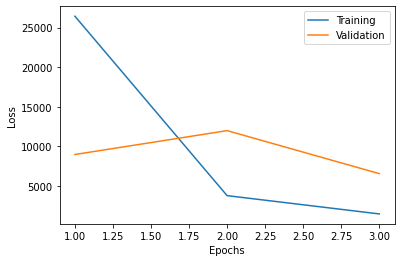

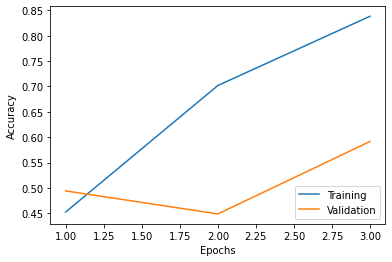

11/11 [==============================] - 2s 123ms/step - loss: 8101.9473 - accuracy: 0.5511


[8101.947265625, 0.5511363744735718]

In [ ]:
del my_model2
l3 = tf.keras.layers.Dense(256, activation='relu')
l4 = tf.keras.layers.Dense(128, activation='relu')
prediction_layer2 = tf.keras.layers.Dense(5, activation="softmax") #5 classi

inputs2 = tf.keras.Input(shape=(224, 224, 3))
x2 = preprocess_input(inputs2)
x2 = model2(x2, training=False)
x2 = tf.keras.layers.Flatten()(x2)
x2 = l3(x2)
x2 = l4(x2)
outputs2 = prediction_layer2(x2)
my_model2 = tf.keras.Model(inputs2, outputs2)

#Checking the final model summary
my_model2.summary()

base_learning_rate = 0.001
my_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history2 = my_model2.fit(train_ds,
                    epochs=n_epochs,
                    validation_data=val_ds)

#Plot training and validation
plot_history(history2)
#Test loss and accuracy
my_model2.evaluate(test_ds.take(-1))

Questo modello è quello che ha il maggior numero di parametri trainabili (Trainable params: 102,794,245) e risulta quindi quello più difficile da allenare, specie con il nostro dataset di soli 3670 elementi. A causa di ciò diverse run portano a risultati anche significativamente diversi, il modello risulta quindi poco stabile. La test accuracy risultate è circa del 55%.

# Taglio 3

Ripetiamo il procedimento cambiando il punto di "taglio" della VGG16. In particolare prendiamo fino al layer 'fc1'. In questo caso non è stata utilizzata la Flatten dato che si era già nella condizione di avere un layer monodimensionale.

In [ ]:
model3 = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
model3.trainable = False
model3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model_4 (Functional)        (None, 4096)              117479232 
                                                                 
 dense_6 (Dense)             (None, 256)               1048832   
                                                                 
 dense_7 (Dense)             (None, 128)               3289

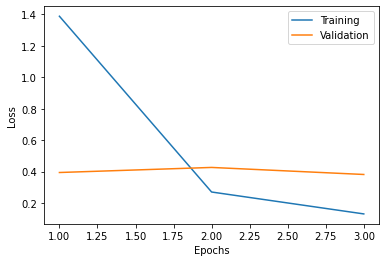

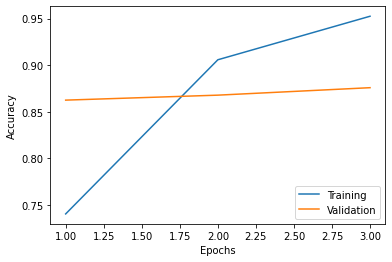

11/11 [==============================] - 3s 250ms/step - loss: 0.5081 - accuracy: 0.8381


[0.5081045627593994, 0.8380681872367859]

In [ ]:
l5 = tf.keras.layers.Dense(256, activation='relu')
l6 = tf.keras.layers.Dense(128, activation='relu')
prediction_layer3 = tf.keras.layers.Dense(5, activation="softmax") #5 classi
inputs3 = tf.keras.Input(shape=(224, 224, 3))

x3 = preprocess_input(inputs3)
x3 = model3(x3, training=False)
# x = tf.keras.layers.Flatten()(x)
x3 = l5(x3)
x3 = l6(x3)
outputs3 = prediction_layer3(x3)
my_model3 = tf.keras.Model(inputs3, outputs3)

#Checking the final model summary
my_model3.summary()

base_learning_rate = 0.001
my_model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history3 = my_model3.fit(train_ds,
                    epochs=n_epochs,
                    validation_data=val_ds)

plot_history(history3)

my_model3.evaluate(test_ds.take(-1))

La test accuracy risultante è di circa 84%. Non si è ancora entrati del tutto in overfitting.

# Considerazioni

Riassumendo:
- Taglio n.1: 
block4_pool, test accuracy 80%, Trainable params: 25,723,909, Non-trainable params: 7,635,264
- Taglio n.2: 
block2_pool, test accuracy 55%, Trainable params: 102,794,245, Non-trainable params: 260,160
- Taglio n.3: 
fc1, test accuracy 84%, Trainable params: 1,082,373, Non-trainable params: 117,479,232

Ciò che si evince dai risultati è che un dataset molto piccolo come il nostro funziona meglio se il taglio della rete VGG16 viene effettuato verso i layer finali, e quindi sfruttando le feature ad un livello relativamente alto. Al contrario, se si cerca di sfruttare le feature di più basso livello (ad esempio linee ed angoli) come nel taglio n.2 si ottengono performance inferiori e se si cerca di incrementare il numero di epochs si va in overfitting. In questo ultimo caso viene sfruttata poco la conoscenza fornita dalla VGG16 e non si è in grado date le dimensioni ridotte del dataset di incrementare di molto l'apprendimento. Nel taglio n.1 si ottiene un risultato intermedio, ma piuttosto vicino (sia come posizione del taglio che come performance) al taglio n.3.

Il numero di parametri addestrabili è inoltre decrescente con il crescere dei livelli importati dalla VGG16, caratteristica che rende anche più facile e veloce l'apprendimento dagli ultimi layer.